In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from scipy import stats
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
#Reading the dataset
merged_df = pd.read_csv("Merged_raw.csv")

In [3]:
#'linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'


## Identifying columns with only one unique value:

In [4]:
uniq_val_col = [col for col in merged_df.columns if merged_df[col].nunique()==1]
uniq_val_col

[' Bwd PSH Flags',
 ' Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [5]:
# Inspecting columns with unique value:

uniq_val_info = {}

for col in merged_df.columns:
    uniq_val = merged_df[col].unique()
    if len(uniq_val) == 1:
        uniq_val_info[col] = {
            "Unique Value": uniq_val[0],
            "Unique Value Count": merged_df[col].count()
        }
        
uniq_val_info_df = pd.DataFrame.from_dict(uniq_val_info, orient ="index")

uniq_val_info_df

Unique Value  Unique Value Count
 Bwd PSH Flags                    0             2830743
 Bwd URG Flags                    0             2830743
Fwd Avg Bytes/Bulk                0             2830743
 Fwd Avg Packets/Bulk             0             2830743
 Fwd Avg Bulk Rate                0             2830743
 Bwd Avg Bytes/Bulk               0             2830743
 Bwd Avg Packets/Bulk             0             2830743
Bwd Avg Bulk Rate                 0             2830743

In [6]:
# Creating a dataset which is clear from unnecessary columns
clear = merged_df.drop(columns = [' Bwd PSH Flags',' Bwd URG Flags','Fwd Avg Bytes/Bulk',
                                  ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',' Bwd Avg Bytes/Bulk',
                                  ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'])
clear.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                       6   
4                             0                       6   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                       6                      6.0                     0.0   
1                       6                      6.0                     0.0   
2                       6                      6.0                     0.0   
3                       6                      6.0                     0.0   
4                       6                      6.0                     0.0   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...                     20          0.0          0.0            0   
1  ...                     20          0.0          0.0            0   
2  ...                     20          0.0          0.0            0   
3  ...                     20          0.0          0.0            0   
4  ...                     20          0.0          0.0            0   

    Active Min  Idle Mean   Idle Std   Idle Max   Idle Min   Label  
0            0        0.0        0.0          0          0  BENIGN  
1            0        0.0        0.0          0          0  BENIGN  
2            0        0.0        0.0          0          0  BENIGN  
3            0        0.0        0.0          0          0  BENIGN  
4            0        0.0        0.0          0          0  BENIGN  

[5 rows x 71 columns]

##
## Inspecting dataset for Missing values

In [7]:
# Inspecting the columns with missing values and their count

mis_val_count = clear.isnull().sum() 
mis_val_perc = (mis_val_count/len(clear))*100
mis_val_sum = pd.DataFrame({
    "Missing Count": mis_val_count,
    "Missing Percenteges": mis_val_perc})

mis_val_sum = mis_val_sum[mis_val_sum["Missing Count"]> 0]
mis_val_sum = mis_val_sum.sort_values(by="Missing Percenteges", ascending = False)

print(mis_val_sum)

              Missing Count  Missing Percenteges
Flow Bytes/s           1358             0.047973


In [8]:
# Creating a list with indexes of rows which contain missing values.
clear.index[clear.isna().any(axis=1)].tolist()

[6796,
 14739,
 15047,
 209728,
 238569,
 238572,
 239937,
 266452,
 278201,
 282348,
 302294,
 302518,
 451591,
 463713,
 463761,
 465331,
 478959,
 484821,
 485427,
 523044,
 533113,
 536001,
 538586,
 546753,
 548314,
 549095,
 551941,
 562024,
 570005,
 575919,
 583028,
 599969,
 619552,
 632494,
 635152,
 638493,
 638614,
 642370,
 643598,
 644053,
 644194,
 647487,
 671087,
 677069,
 683989,
 692612,
 701417,
 707231,
 722150,
 724308,
 725039,
 728916,
 733244,
 745983,
 746511,
 751523,
 752588,
 762875,
 771091,
 773413,
 778115,
 780665,
 787254,
 804340,
 817796,
 843167,
 862326,
 873854,
 875193,
 876222,
 883179,
 885743,
 897088,
 897933,
 901489,
 906620,
 916144,
 930161,
 931189,
 943639,
 974593,
 976119,
 985642,
 1011934,
 1016022,
 1023691,
 1028233,
 1038847,
 1043830,
 1046531,
 1059791,
 1066699,
 1076704,
 1082313,
 1113368,
 1113810,
 1114181,
 1118714,
 1119405,
 1125216,
 1127809,
 1130295,
 1140267,
 1144402,
 1151499,
 1154275,
 1175827,
 1179754,
 118164

##
## Inspecting the dataframe for mistakes during the merging phase

In [9]:
clear.iloc[6795:6798, 13:17]

# While working with column Flow Bytes/s, "inf" type values in "Flow Packets/s" column were discovered

Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean
6795                     0.0           0.0        2000000.0             1.0
6796                     0.0           NaN              inf             0.0
6797                     0.0           0.0         500000.0             4.0

In [10]:
#Inspecting the columns with missing values based on index
clear.iloc[15045:15049, 13:17]

Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean
15045                0.000000      0.000000     1.694915e+04           118.0
15046              404.145188   2776.156732     1.667361e+01         71970.0
15047                0.000000           NaN              inf             0.0
15048              594.093427   3657.495387     1.652483e+01         72618.0

In [11]:
#Replacing "inf" values with NaN values to eliminate them
clear.replace([np.inf, -np.inf], np.nan, inplace = True)

print(clear.iloc[6795:6798, 13:17]) #Checking if the replacement was successful

       Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s   Flow IAT Mean
6795                     0.0           0.0        2000000.0             1.0
6796                     0.0           NaN              NaN             0.0
6797                     0.0           0.0         500000.0             4.0


#### Now repeating the process 

In [12]:
# Creating a list with indexes of rows with missing values. 

clear.index[clear.isna().any(axis=1)].tolist()

[65,
 1767,
 1890,
 3375,
 6796,
 8057,
 8405,
 13313,
 13716,
 14739,
 15047,
 18253,
 33330,
 55551,
 61529,
 88091,
 130668,
 148284,
 174379,
 174394,
 189925,
 194128,
 200349,
 201237,
 203979,
 204238,
 204640,
 208999,
 209728,
 213594,
 214432,
 214453,
 215026,
 216496,
 225993,
 230750,
 237227,
 238569,
 238572,
 239937,
 243055,
 248216,
 256218,
 260649,
 261754,
 264197,
 264238,
 265317,
 265321,
 266452,
 267379,
 269794,
 278201,
 280386,
 282312,
 282348,
 283722,
 283856,
 285959,
 286021,
 286030,
 287244,
 287512,
 293087,
 295164,
 295859,
 297141,
 300515,
 300518,
 300724,
 302294,
 302417,
 302518,
 302693,
 302922,
 304945,
 305962,
 308541,
 309287,
 309360,
 314080,
 314092,
 316852,
 317094,
 317415,
 317725,
 317911,
 317943,
 318082,
 318188,
 318464,
 318571,
 320301,
 321607,
 322545,
 323009,
 323073,
 324271,
 324585,
 325868,
 325893,
 326633,
 326876,
 327124,
 328474,
 328876,
 329850,
 331762,
 332158,
 332931,
 333569,
 334268,
 334286,
 336071,

In [13]:
# Inspecting the columns with missing values and their count

mis_val_count = clear.isnull().sum()
mis_val_perc = (mis_val_count/len(clear))*100
mis_val_sum = pd.DataFrame({
    "Missing Count": mis_val_count,
    "Missing Percenteges": mis_val_perc})

mis_val_sum = mis_val_sum[mis_val_sum["Missing Count"]>0]
mis_val_sum = mis_val_sum.sort_values(by="Missing Percenteges", ascending = False)

print(mis_val_sum)

                 Missing Count  Missing Percenteges
Flow Bytes/s              2867             0.101281
 Flow Packets/s           2867             0.101281


In [14]:
#Filtering out the rows with missing values. This can help to check distribution of missing values accross different classes. 

rows_with_mis_val = clear.isnull().any(axis=1)
clear_missing = clear[rows_with_mis_val]
clear_missing[" Label"].value_counts()

BENIGN         1777
DoS Hulk        949
PortScan        126
Bot              10
FTP-Patator       3
DDoS              2
Name:  Label, dtype: int64

In [15]:
#Calculating the number of rows with missing values

num_of_rows = rows_with_mis_val.sum()
num_of_rows

2867

In [16]:
#Dropping Missing values, since they represent less than 1% of each class
clear.dropna()

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2830738                 53           32215                   4   
2830739                 53             324                   2   
2830740              58030              82                   2   
2830741                 53         1048635                   6   
2830742                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2830738                        2                          112   
2830739                        2                           84   
2830740                        1                           31   
2830741                        2                          192   
2830742                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2830738                           152                      28   
2830739                           362                      42   
2830740                             6                      31   
2830741                           256                      32   
2830742                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2830738                      28                     28.0   
2830739                      42                     42.0   
2830740                       0                     15.5   
2830741                      32                     32.0   
2830742                      47                     47.0   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                       0.00000  ...                     20          0.0   
1                       0.00000  ...                     20          0.0   
2                       0.00000  ...                     20          0.0   
3                       0.00000  ...                     20          0.0   
4                       0.00000  ...                     20          0.0   
...                         ...  ...                    ...          ...   
2830738                 0.00000  ...                     20          0.0   
2830739                 0.00000  ...                     20          0.0   
2830740                21.92031  ...                     32          0.0   
2830741                 0.00000  ...                     20          0.0   
2830742                 0.00000  ...                     20          0.0   

          Active Std 

In [17]:
#Saving the dataframe free from the missing vales into new dataframe
clear_new = clear.dropna()
clear_new.isnull().sum().sum() # doublechecking the "clear_new" dataframe for Missing values

0

##
## Checking the Dataset for Duplicates

In [18]:
# Total number of duplicated values
clear_new.duplicated().sum()

307078

In [19]:
# Trying to identify which classes have duplicated instances:

duplicated_rows = clear_new[clear_new.duplicated(keep=False)] # to identify duplicated rows

duplicated_count = duplicated_rows[" Label"].value_counts() # sum of duplicated values per class

duplicated_count

BENIGN                      235815
PortScan                    101499
DoS Hulk                     58615
SSH-Patator                   2826
FTP-Patator                   2455
DoS slowloris                  507
DoS Slowhttptest               323
Web Attack � Brute Force        62
DDoS                            20
DoS GoldenEye                   14
Bot                             13
Name:  Label, dtype: int64

In [20]:
# After careful research the decision to drop the duplicated values was taken:
df_cleaned = clear_new.drop_duplicates()
df_cleaned

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2830738                 53           32215                   4   
2830739                 53             324                   2   
2830740              58030              82                   2   
2830741                 53         1048635                   6   
2830742                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2830738                        2                          112   
2830739                        2                           84   
2830740                        1                           31   
2830741                        2                          192   
2830742                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2830738                           152                      28   
2830739                           362                      42   
2830740                             6                      31   
2830741                           256                      32   
2830742                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2830738                      28                     28.0   
2830739                      42                     42.0   
2830740                       0                     15.5   
2830741                      32                     32.0   
2830742                      47                     47.0   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                       0.00000  ...                     20          0.0   
1                       0.00000  ...                     20          0.0   
2                       0.00000  ...                     20          0.0   
3                       0.00000  ...                     20          0.0   
4                       0.00000  ...                     20          0.0   
...                         ...  ...                    ...          ...   
2830738                 0.00000  ...                     20          0.0   
2830739                 0.00000  ...                     20          0.0   
2830740                21.92031  ...                     32          0.0   
2830741                 0.00000  ...                     20          0.0   
2830742                 0.00000  ...                     20          0.0   

          Active Std 

In [21]:
# Doublechecking the dataset for Missing values and duplicates.

df_cleaned.isnull().sum().sum()
df_cleaned.duplicated().sum()

0

In [22]:
# Saving the dataset without missing and duplicated values 
df_cleaned.to_csv("Cleaned_no_miss_val_or_duplic_val.csv", sep=',', index=False, encoding='utf-8') #important

##
## Checking Correlation of the Features

In [23]:
# Creating correlation matrix
numeric_df = df_cleaned.select_dtypes(include=[np.number])

cor_matrix = numeric_df.corr()

threshold = 0.95
high_cor_pairs = []

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if abs(cor_matrix.iloc[i,j])> threshold:
            colname_i = cor_matrix.columns[i]
            colname_j = cor_matrix.columns[j]
            high_cor_pairs.append((colname_i, colname_j, cor_matrix.iloc[i,j]))
            
high_cor_df = pd.DataFrame(high_cor_pairs, columns = ["Feature_1", "Feature_2", "Correlation"])
high_cor_df

Feature_1                     Feature_2  Correlation
0         Total Backward Packets             Total Fwd Packets     0.999070
1    Total Length of Bwd Packets             Total Fwd Packets     0.996993
2    Total Length of Bwd Packets        Total Backward Packets     0.994430
3          Fwd Packet Length Std         Fwd Packet Length Max     0.968529
4         Bwd Packet Length Mean         Bwd Packet Length Max     0.958174
5          Bwd Packet Length Std         Bwd Packet Length Max     0.982514
6                  Fwd IAT Total                 Flow Duration     0.998529
7                    Fwd IAT Max                  Flow IAT Max     0.998053
8                  Fwd Packets/s                Flow Packets/s     0.980473
9              Packet Length Std             Max Packet Length     0.984037
10                SYN Flag Count                 Fwd PSH Flags     1.000000
11                CWE Flag Count                 Fwd URG Flags     1.000000
12                ECE Flag Count                RST Flag Count     0.997820
13           Average Packet Size            Packet Length Mean     0.997823
14          Avg Fwd Segment Size        Fwd Packet Length Mean     1.000000
15          Avg Bwd Segment Size         Bwd Packet Length Max     0.958174
16          Avg Bwd Segment Size        Bwd Packet Length Mean     1.000000
17           Fwd Header Length.1             Fwd Header Length     1.000000
18           Subflow Fwd Packets             Total Fwd Packets     1.000000
19           Subflow Fwd Packets        Total Backward Packets     0.999070
20           Subflow Fwd Packets   Total Length of Bwd Packets     0.996993
21             Subflow Fwd Bytes   Total Length of Fwd Packets     0.999999
22           Subflow Bwd Packets             Total Fwd Packets     0.999070
23           Subflow Bwd Packets        Total Backward Packets     1.000000
24           Subflow Bwd Packets   Total Length of Bwd Packets     0.994430
25           Subflow Bwd Packets           Subflow Fwd Packets     0.999070
26             Subflow Bwd Bytes             Total Fwd Packets     0.996987
27             Subflow Bwd Bytes        Total Backward Packets     0.994424
28             Subflow Bwd Bytes   Total Length of Bwd Packets     1.000000
29             Subflow Bwd Bytes           Subflow Fwd Packets     0.996987
30             Subflow Bwd Bytes           Subflow Bwd Packets     0.994424
31                     Idle Mean                  Flow IAT Max     0.979850
32                     Idle Mean                   Fwd IAT Max     0.978224
33                      Idle Max                  Flow IAT Max     0.989483
34                      Idle Max                   Fwd IAT Max     0.988632
35                      Idle Max                     Idle Mean     0.990237
36                      Idle Min                  Flow IAT Max     0.951227
37                      Idle Min                     Idle Mean     0.990079
38                      Idle Min                      Idle Max     0.961251

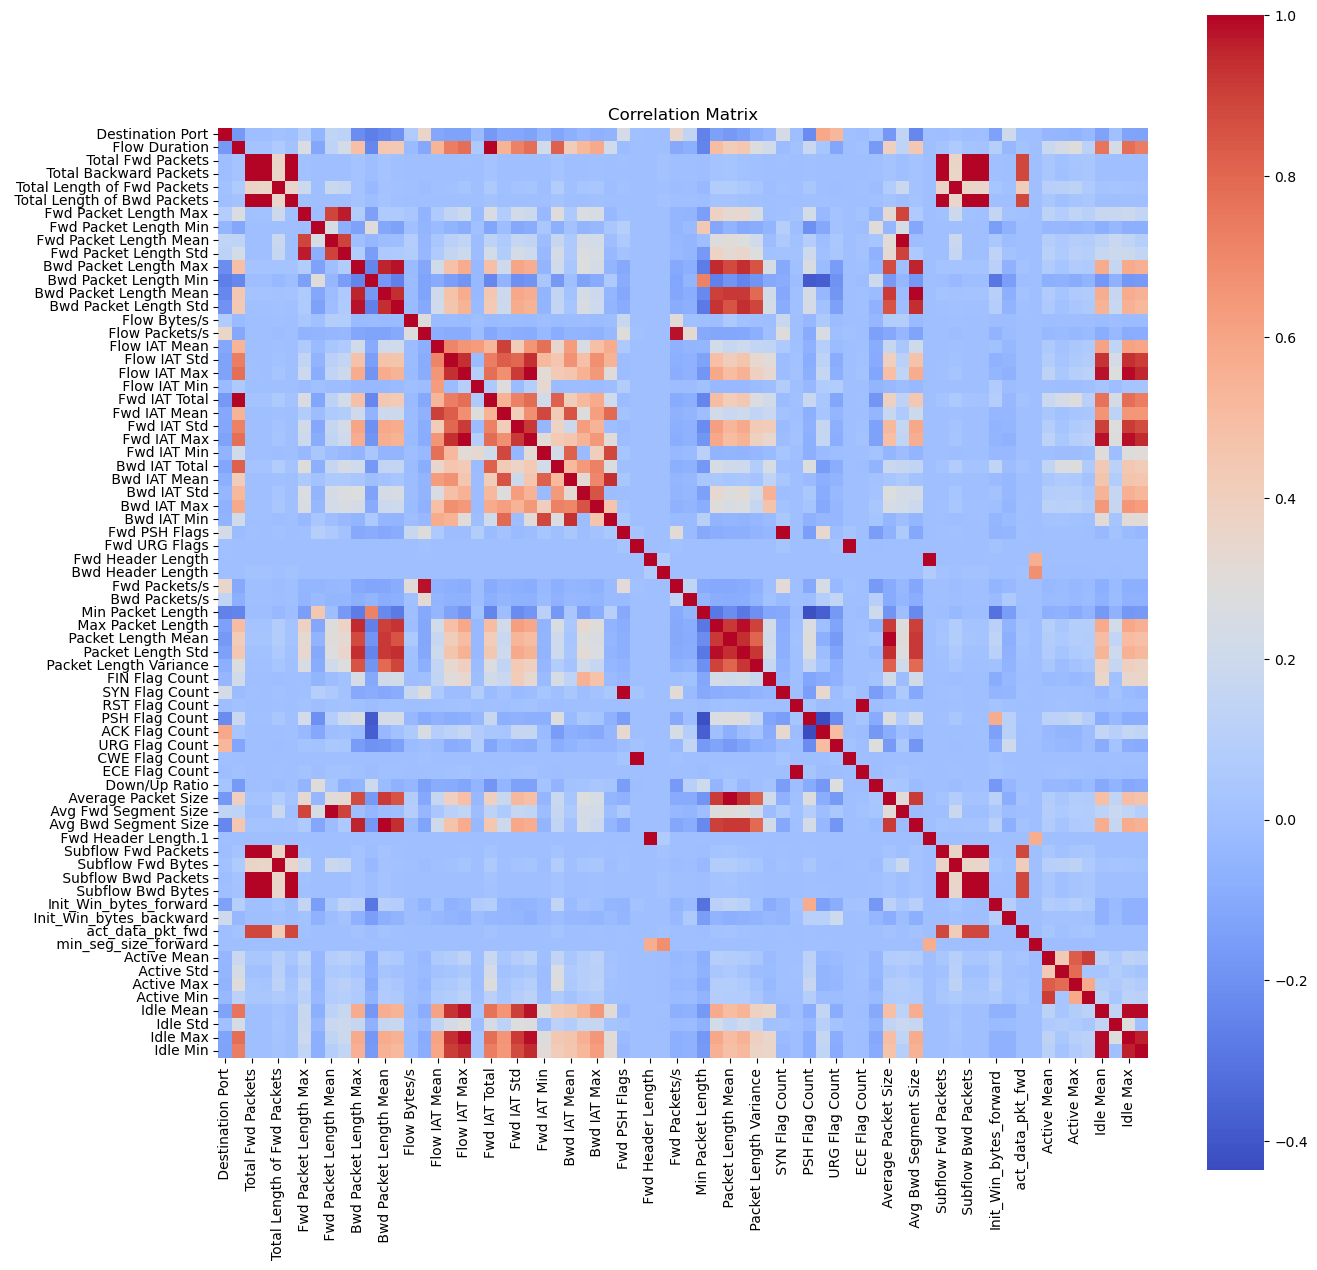

In [24]:
# Plot correlation
plt.figure(figsize=(15,15))
sns.heatmap(cor_matrix, annot=False, cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [25]:
# Creating a table with correlated features sorted by attack type
numeric_df

attack_types = df_cleaned[' Label'].unique()

# Set a threshold for high correlation
threshold = 0.95

# Dictionary to hold high correlation pairs for each attack type
high_corr_dict = {}

# Iterate over each attack type
for attack in attack_types:
    # Filter the dataset for the current attack type
    attack_df = df_cleaned[df_cleaned[' Label'] == attack]
    
    # Ensure only numeric columns are used
    numeric_attack_df = attack_df.select_dtypes(include=[np.number])
    
    # Create the correlation matrix
    corr_matrix = numeric_attack_df.corr()
    
    # Find pairs of highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                high_corr_pairs.append((colname_i, colname_j, corr_matrix.iloc[i, j]))
    
    # Store the results in the dictionary
    high_corr_dict[attack] = high_corr_pairs

# Create a DataFrame for each attack type's high correlation pairs
high_corr_df_list = []
for attack, pairs in high_corr_dict.items():
    attack_df = pd.DataFrame(pairs, columns=['Feature_1', 'Feature_2', 'Correlation'])
    attack_df['Attack_Type'] = attack
    high_corr_df_list.append(attack_df)

# Combine all DataFrames into a single DataFrame
high_corr_all_df = pd.concat(high_corr_df_list, ignore_index=True)

# Display the table of highly correlated pairs for each attack type
high_corr_all_df

Feature_1                Feature_2  Correlation  \
0           Total Backward Packets        Total Fwd Packets     0.999078   
1      Total Length of Bwd Packets        Total Fwd Packets     0.997028   
2      Total Length of Bwd Packets   Total Backward Packets     0.994453   
3            Fwd Packet Length Std    Fwd Packet Length Max     0.969319   
4                    Fwd IAT Total            Flow Duration     0.997824   
...                            ...                      ...          ...   
2819                      Idle Min              Active Mean     1.000000   
2820                      Idle Min               Active Max     1.000000   
2821                      Idle Min               Active Min     1.000000   
2822                      Idle Min                Idle Mean     1.000000   
2823                      Idle Min                 Idle Max     1.000000   

     Attack_Type  
0         BENIGN  
1         BENIGN  
2         BENIGN  
3         BENIGN  
4         BENIGN  
...          ...  
2819  Heartbleed  
2820  Heartbleed  
2821  Heartbleed  
2822  Heartbleed  
2823  Heartbleed  

[2824 rows x 4 columns]

In [26]:
reduced_df = df_cleaned.copy()
reduced_df

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2830738                 53           32215                   4   
2830739                 53             324                   2   
2830740              58030              82                   2   
2830741                 53         1048635                   6   
2830742                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2830738                        2                          112   
2830739                        2                           84   
2830740                        1                           31   
2830741                        2                          192   
2830742                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2830738                           152                      28   
2830739                           362                      42   
2830740                             6                      31   
2830741                           256                      32   
2830742                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2830738                      28                     28.0   
2830739                      42                     42.0   
2830740                       0                     15.5   
2830741                      32                     32.0   
2830742                      47                     47.0   

          Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
0                       0.00000  ...                     20          0.0   
1                       0.00000  ...                     20          0.0   
2                       0.00000  ...                     20          0.0   
3                       0.00000  ...                     20          0.0   
4                       0.00000  ...                     20          0.0   
...                         ...  ...                    ...          ...   
2830738                 0.00000  ...                     20          0.0   
2830739                 0.00000  ...                     20          0.0   
2830740                21.92031  ...                     32          0.0   
2830741                 0.00000  ...                     20          0.0   
2830742                 0.00000  ...                     20          0.0   

          Active Std 

##
## Feature Selection based on the Information Gain 

In [27]:
# Ensure only numeric columns are used for correlation calculation
numeric_df = reduced_df.select_dtypes(include=[np.number])

# Assuming 'Label' is the target column
X = reduced_df.drop(columns=[' Label'])
y = reduced_df[' Label']

# Compute information gain
info_gain = mutual_info_classif(X, y, discrete_features='auto')

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Information_Gain': info_gain
})

# Sort features by information gain
feature_importance = feature_importance.sort_values(by='Information_Gain', ascending=False)

# Select top N features (example: top 14 features)
top_features = feature_importance.head(20)['Feature'].values
df_selected = reduced_df[top_features].copy()

# Add the target column back using .loc
df_selected.loc[:, ' Label'] = y.values

# Print selected features to determine the actual feature names
print("Selected Features based on Information Gain:")
print(df_selected.columns)

# Example of creating interaction terms with actual feature names
actual_feature1 = 'Total Length of Fwd Packets'
actual_feature2 = 'Total Length of Bwd Packets'

# Check if the features exist in the DataFrame
if actual_feature1 in df_selected.columns and actual_feature2 in df_selected.columns:
    df_selected['interaction_feature'] = df_selected[actual_feature1] * df_selected[actual_feature2]
else:
    print(f"Error: '{actual_feature1}' or '{actual_feature2}' not found in DataFrame columns")

Selected Features based on Information Gain:
Index([' Average Packet Size', ' Packet Length Mean', ' Packet Length Std',
       ' Packet Length Variance', ' Total Length of Bwd Packets',
       ' Subflow Bwd Bytes', ' Avg Bwd Segment Size',
       ' Bwd Packet Length Mean', ' Subflow Fwd Bytes',
       'Total Length of Fwd Packets', 'Bwd Packet Length Max',
       'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
       ' Max Packet Length', ' Fwd Packet Length Max', ' Fwd IAT Max',
       ' Flow IAT Max', 'Fwd IAT Total', ' Flow Duration',
       ' Fwd Header Length', ' Label'],
      dtype='object')
Error: 'Total Length of Fwd Packets' or 'Total Length of Bwd Packets' not found in DataFrame columns


In [28]:
feature_importance.to_pickle("feature_importance_info_gain.pkl")

In [29]:
df_selected.to_csv("Preprocessed2.csv", sep=',', index=False, encoding='utf-8') ## Important

##
## Feature Selection using Random Forest Classifier

In [30]:
%%time

# Separate features and labels
X = reduced_df.drop(columns=[' Label'])  # Drop the ' Label' column to get features
y = reduced_df[' Label']  # The ' Label' column contains the labels

# Encode the labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_scaled, y_encoded)

# Calculate feature importance
importance = model.feature_importances_

# Multiply by the standardized mean value of each feature
mean_values = X_scaled.mean(axis=0)
importance_scores = mean_values * importance

# Create a DataFrame to store feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance Score': importance_scores
})

# Sort the features by importance score
importance_df = importance_df.sort_values(by='Importance Score', ascending=False)

# Save the feature importance to a file if needed
importance_df.to_csv('feature_importance_.csv', index=False)

# Print the sorted feature importance DataFrame
print("Sorted Feature Importance:")
print(importance_df)

Sorted Feature Importance:
                    Feature  Importance Score
39        Packet Length Std      3.457087e-18
13    Bwd Packet Length Std      2.105163e-18
12   Bwd Packet Length Mean      1.132228e-18
22              Fwd IAT Std      9.662018e-19
21             Fwd IAT Mean      7.993673e-19
..                      ...               ...
17             Flow IAT Std     -3.044292e-18
38       Packet Length Mean     -4.924794e-18
8    Fwd Packet Length Mean     -5.628303e-18
51     Avg Fwd Segment Size     -6.554257e-18
40   Packet Length Variance     -1.440265e-17

[70 rows x 2 columns]
CPU times: total: 10min 54s
Wall time: 10min 55s


In [31]:
# best features
importance_df["Feature"].unique() # Random Forest Classifier 
best_features = importance_df["Feature"].head(24).values
best_features

array([' Packet Length Std', ' Bwd Packet Length Std',
       ' Bwd Packet Length Mean', ' Fwd IAT Std', ' Fwd IAT Mean',
       ' Idle Max', 'Init_Win_bytes_forward', ' Bwd Packets/s',
       ' PSH Flag Count', 'Flow Bytes/s', ' Bwd IAT Std',
       ' Flow Duration', 'Total Length of Fwd Packets', 'Active Mean',
       ' Active Max', ' Bwd IAT Min', ' Down/Up Ratio',
       ' Subflow Fwd Bytes', ' Bwd IAT Max', 'Bwd IAT Total',
       ' Subflow Bwd Packets', ' Active Min', ' Bwd IAT Mean',
       ' Active Std'], dtype=object)

In [32]:
# Information Gain best features
feature_importance["Feature"].unique()

array([' Average Packet Size', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance',
       ' Total Length of Bwd Packets', ' Subflow Bwd Bytes',
       ' Avg Bwd Segment Size', ' Bwd Packet Length Mean',
       ' Subflow Fwd Bytes', 'Total Length of Fwd Packets',
       'Bwd Packet Length Max', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' Max Packet Length',
       ' Fwd Packet Length Max', ' Fwd IAT Max', ' Flow IAT Max',
       'Fwd IAT Total', ' Flow Duration', ' Fwd Header Length',
       ' Fwd Header Length.1', ' Fwd Packet Length Mean',
       ' Avg Fwd Segment Size', ' Fwd IAT Mean', 'Flow Bytes/s',
       ' Bwd Packet Length Std', ' Destination Port',
       ' Bwd Header Length', 'Fwd Packets/s', ' Fwd Packet Length Std',
       ' Bwd Packets/s', ' Flow IAT Mean', ' Flow Packets/s',
       ' Fwd IAT Std', ' Flow IAT Std', ' Bwd IAT Max', 'Bwd IAT Total',
       ' Bwd IAT Mean', ' Subflow Bwd Packets', ' Total Backward Packets',
      

In [34]:
# Create the new DataFrame with the cleaned feature names
selected_features_df = reduced_df[best_features].copy()
# add the target column back to the new DataFrame
selected_features_df[' Label'] = reduced_df[' Label']
# Display the DataFrame with the selected features
selected_features_df.to_csv('Final_data.csv', index=False)

In [39]:
selected_features_df

Packet Length Std   Bwd Packet Length Std   Bwd Packet Length Mean  \
0                  0.000000                     0.0                      0.0   
1                  0.000000                     0.0                      6.0   
2                  0.000000                     0.0                      6.0   
3                  0.000000                     0.0                      6.0   
4                  0.000000                     0.0                      0.0   
...                     ...                     ...                      ...   
2830738           23.421602                     0.0                     76.0   
2830739           76.133435                     0.0                    181.0   
2830740           16.350331                     0.0                      6.0   
2830741           42.332021                     0.0                    128.0   
2830742           32.204702                     0.0                    113.0   

          Fwd IAT Std   Fwd IAT Mean   Idle Max  Init_Win_bytes_forward  \
0             0.00000        3.00000          0                      33   
1             0.00000        0.00000          0                      29   
2             0.00000        0.00000          0                      29   
3             0.00000        0.00000          0                      31   
4             0.00000        3.00000          0                      32   
...               ...            ...        ...                     ...   
2830738   17755.84381    10277.33333          0                      -1   
2830739       0.00000        2.00000          0                      -1   
2830740       0.00000        4.00000          0                    1006   
2830741  444210.06860   206722.60000          0                      -1   
2830742   42174.28246    24350.33333          0                      -1   

          Bwd Packets/s   PSH Flag Count  Flow Bytes/s  ...   Bwd IAT Min  \
0              0.000000                0  4.000000e+06  ...             0   
1           9174.311927                0  1.100917e+05  ...             0   
2          19230.769230                0  2.307692e+05  ...             0   
3          29411.764710                0  3.529412e+05  ...             0   
4              0.000000                0  4.000000e+06  ...             0   
...                 ...              ...           ...  ...           ...   
2830738       62.082881                0  8.194940e+03  ...             3   
2830739     6172.839506                0  1.376543e+06  ...             2   
2830740    12195.121950                0  4.512195e+05  ...             0   
2830741        1.907241                0  4.272221e+02  ...             3   
2830742       21.066158                0  4.360695e+03  ...            48   

          Down/Up Ratio   Subflow Fwd Bytes   Bwd IAT Max  Bwd IAT Total  \
0                     0                  12             0              0   
1                     1                   6             0              0   
2                     1                   6             0              0   
3                     1                   6             0              0   
4                     0                  12             0              0   
...                 ...                 ...           ...            ...   
2830738               0                 112             3              3   
2830739               1                  84             2              2   
2830740               0                  31             0              0   
2830741               0                 192             3              3   
2830742               0                 188            48             48   

          Subflow Bwd Packets   Active Min   Bwd IAT Mean   Active Std   Label  
0                           0            0            0.0          0.0  BENIGN  
1                           1            0            0.0          0.0  BENIGN  
2                           1            0            0.0          

In [35]:
# Dataframe with top features selected by RandomForest Classifier
selected_features_df[" Label"].value_counts() 

BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64

In [36]:
# Replace the specific Web Attack classes with a single label "Web Attack"
selected_features_df[' Label'] = selected_features_df[' Label'].replace({
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack'
})

# Check the updated class distribution
print(selected_features_df[' Label'].value_counts())

selected_features_df.to_csv('Final_data_13_classes.csv', index=False)

BENIGN              2095057
DoS Hulk             172846
DDoS                 128014
PortScan              90694
DoS GoldenEye         10286
FTP-Patator            5931
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Web Attack             2143
Bot                    1948
Infiltration             36
Heartbleed               11
Name:  Label, dtype: int64


In [37]:
inform_gain = pd.read_csv("Preprocessed2.csv")

# Replace all specific "Web Attack" types with "Web Attack"
inform_gain[" Label"] = inform_gain[" Label"].replace({
    "Web Attack � Brute Force": "Web Attack",
    "Web Attack � XSS": "Web Attack",
    "Web Attack � Sql Injection": "Web Attack"
})

# Now check if all Web Attack labels are combined
print(inform_gain[" Label"].value_counts())
inform_gain.to_csv("Preprocessed2_merged.csv", index=False)

BENIGN              2095057
DoS Hulk             172846
DDoS                 128014
PortScan              90694
DoS GoldenEye         10286
FTP-Patator            5931
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Web Attack             2143
Bot                    1948
Infiltration             36
Heartbleed               11
Name:  Label, dtype: int64
